In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import skimage
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

In [3]:
image = np.asarray(Image.open("data/binary.png").convert('1'))

In [4]:
image.shape

(542, 980)

In [5]:
image.dtype

dtype('bool')

In [6]:
def show_image(image):
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='gray')
    plt.show()

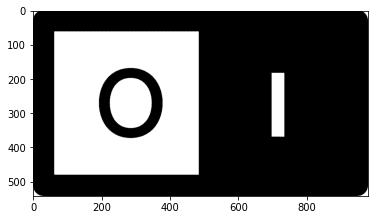

In [7]:
show_image(image)

Применим шум по модели "Соль и перец"

p = P{1 -> 0} = 0.03

q = P{0 -> 1} = 0.08

In [8]:
def add_noise(image, p=0.5, q=0.5, inplace=False):
    result = image.copy() if not inplace else image
    prob = np.random.rand(*image.shape)
    result[image & (prob < p)] = False
    result[~image & (prob < q)] = True
    return result

In [9]:
noised = add_noise(image, p=0.03, q=0.08)

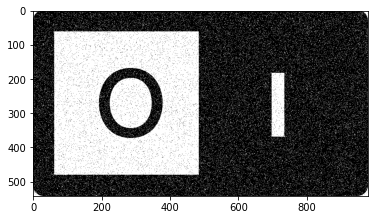

In [10]:
show_image(noised)

In [11]:
def rank_filter(image, n, k):
    assert n**2 > k
    h, w = image.shape
    res_h, res_w = h - h % n, w - w % n  # H', W'
    
    patches = skimage.util.view_as_windows(image, n).reshape(res_h, res_w, n**2)  # (H', W', n^2)
    one_counts = patches.sum(-1)  # (H', W')
    result = (one_counts >= k)
    return result

def logical_xor(image1, image2):
    if image1.shape == image2.shape:
        return np.logical_xor(image1, image2)
    
    h1, w1 = image1.shape
    h2, w2 = image2.shape
            
    min_h, min_w = min(h1, h2), min(w1, w2)
    o_h = (max(h1, h2) - min_h) // 2
    o_w = (max(w1, w2) - min_w) // 2
    
    if h2 > h1:
        image2 = image2[o_h:o_h + min_h]
    elif h1 > h2:
        image1 = image1[o_h:o_h + min_h]
        
    if w2 > w1:
        image2 = image2[:, o_w:o_w + min_w]
    elif w1 > w2:
        image1 = image1[:, o_w:o_w + min_w]
            
    result = np.logical_xor(image1, image2)
    return result

def weighted_rank_filter(image, aperture):
    n = int(aperture.sum())
    h, w = image.shape
    ah, aw = aperture.shape
    res_h, res_w = h - h % ah, w - w % aw  # H', W'
    
    patches = skimage.util.view_as_windows(image, (ah, aw)).reshape(res_h, res_w, ah, aw)  # (H', W', AH, AW)
    
    one_counts = patches.sum((2, 3))  # (H', W')
    k = (patches * aperture).sum((2, 3))  # (H', W')
    n = aperture.sum()
    
    result = (one_counts >= k)
    return result

Ранговая фильтация при n = 9 и различных k = {2, 4, 6, 8}

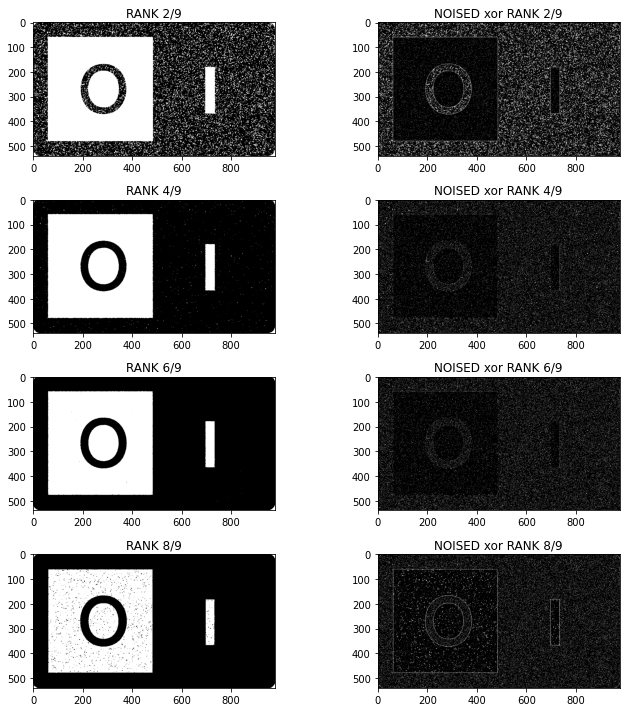

In [12]:
ks = [2, 4, 6, 8]
fig, axes = plt.subplots(len(ks), 2, figsize=(10, 10))

for ax_row, k in enumerate(ks):
    filtered = rank_filter(noised, 3, k)
    xor = logical_xor(noised, filtered)
    assert xor.shape == filtered.shape
    
    axes[ax_row, 0].set_title(f"RANK {k}/9")
    axes[ax_row, 0].imshow(filtered, cmap='gray')
    
    axes[ax_row, 1].set_title(f"NOISED xor RANK {k}/9")
    axes[ax_row, 1].imshow(xor, cmap='gray')
    
fig.tight_layout()
plt.show()

Взвешенная ранговая фильтрация со следующей апертурой:

$
\Omega = \begin{matrix}
1 & 2 & 1\\
2 & 4 & 2\\
1 & 2 & 1
\end{matrix}
$

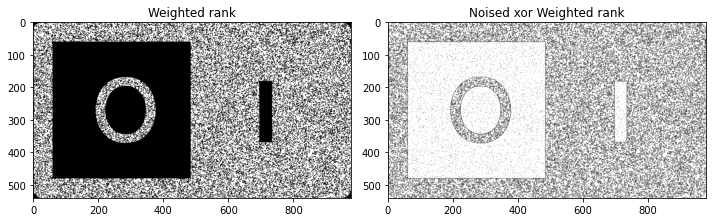

In [13]:
aperture = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1],
])

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

filtered = weighted_rank_filter(noised, aperture)
xor = logical_xor(noised, filtered)

axes[0].set_title(f"Weighted rank")
axes[0].imshow(filtered, cmap='gray')

axes[1].set_title(f"Noised xor Weighted rank")
axes[1].imshow(xor, cmap='gray')

fig.tight_layout()
plt.show()